### Libraries to be used

In [1]:
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
from transformers import pipeline
from __future__ import unicode_literals
import spacy,en_core_web_sm
from spacy.lang.en import English
from spacy.matcher import Matcher
import textacy
import string
from wordcloud import WordCloud, STOPWORDS 
import numpy as np
import nltk
import locationtagger
from difflib import SequenceMatcher
import gensim
from gensim.models import Word2Vec
from gensim import models
import seaborn as sns
import tensorflow as tf
import transformers
from sentence_transformers import SentenceTransformer
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel

C:\Users\Asus\anaconda3\envs\aaaa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The following classes are designed to be used in the tasks three
### For simplicity I have transforme  pickle files to csv file

In [2]:
class MlSkillsOne:
    
    def __init__(self):
        pass
        self.all_records_raw_df = self.read_data_of_individual_topics()
        self.target_phrase = "Jeu de Paume is an excellent art gallery in Paris"        
        self.data_cleaner()
        self.get_score()
        self.corpus = self.all_records_raw_df['name_cleaned'].map(lambda row: [row]).tolist()

    def read_data_of_individual_topics(self):
        
        all_records_df = pd.read_csv("data_full_task_one.csv")[:5000]
       
        return all_records_df
    
    
    def data_cleaner(self):

        self.all_records_raw_df["name_cleaned"] = self.all_records_raw_df.name\
            .apply(lambda row: row.translate(str.maketrans('', '', string.punctuation)))
        
        self.all_records_raw_df["target_phrase"] = self.target_phrase
        
    def word_cloud(self, score):
        string = self.all_records_raw_df[self.all_records_raw_df.score == score].name_cleaned
        comment_words = ''
        stopwords = set(STOPWORDS)
        for val in string:

            # typecaste each val to string
            val = str(val)

            # split the value
            tokens = val.split()

            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()

            comment_words += " ".join(tokens)+" "

        wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

        # plot the WordCloud image                      
        plt.figure(figsize = (4, 4), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)

        plt.show()   
        
    def get_score(self):
        
        sentiment_pipeline = pipeline("sentiment-analysis",
                              model="nlptown/bert-base-multilingual-uncased-sentiment")
        
        self.all_records_raw_df["labels"] = self.all_records_raw_df.name_cleaned.\
                                            apply(lambda x: sentiment_pipeline(x))
        self.all_records_raw_df["score"] = self.all_records_raw_df.labels.\
                                            apply(lambda x: list(x[0].items())[0][1])
        self.all_records_raw_df.drop(["labels"], axis=1, inplace=True)
        
        self.all_records_raw_df.score.replace('5 stars', 5, inplace = True)
        
        self.all_records_raw_df.score.replace('4 stars', 4, inplace = True)
        
        self.all_records_raw_df.score.replace('3 stars', 3, inplace = True)
        
        self.all_records_raw_df.score.replace('2 stars', 2, inplace = True)
        
        self.all_records_raw_df.score.replace('1 star', 1, inplace = True)   

In [3]:
%%time
trantor = MlSkillsOne()

CPU times: total: 13min 7s
Wall time: 19h 26min 37s


## Exercise 3
### Using the multi-lingual model
### 3.1) Make the sentiment score prediction for each of the topics.
### 3.2) Add the scores as a new field of the dataframe (df).

In [4]:
%%time
trantor.get_score()

CPU times: total: 12min 16s
Wall time: 6min 26s


In [5]:
trantor.all_records_raw_df

,Unnamed: 0,id,name,audience_size,country,topic,name_cleaned,target_phrase,score
0,0,6003103801917,Royal Doulton,258710,NaN,NaN,Royal Doulton,Jeu de Paume is an excellent art gallery in Paris,5
1,1,6003554853263,Tower Heist,356610,NaN,NaN,Tower Heist,Jeu de Paume is an excellent art gallery in Paris,1
2,2,6003006086492,Bathstore,32090,NaN,NaN,Bathstore,Jeu de Paume is an excellent art gallery in Paris,4
3,3,6003332326741,Family Guy Fans,37120,NaN,NaN,Family Guy Fans,Jeu de Paume is an excellent art gallery in Paris,4
4,4,6003104481229,Joseph Gordon-Levitt,5866260,NaN,NaN,Joseph GordonLevitt,Jeu de Paume is an excellent art gallery in Paris,4
...,...,...,...,...,...,...,...,...,...
4995,4995,6008193823324,Cleaning,14025777,NaN,NaN,Cleaning,Jeu de Paume is an excellent art gallery in Paris,4
4996,4996,6003352059757,Curious George (serie de televisión),18430,NaN,NaN,Curious George serie de televisión,Jeu de Paume is an excellent art gallery in Paris,4
4997,4997,6003435139283,Condominio,18326583,NaN,NaN,Condominio,Jeu de Paume is an excellent art gallery in Paris,4
4998,4998,6003398767327,Sime Darby,897880,NaN,NaN,Sime Darby,Jeu de Paume is an excellent art gallery in Paris,3


In [6]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

In [7]:
%%time
data_for_training = list(tagged_document(trantor.corpus))
model = gensim.models.doc2vec.Doc2Vec(vector_size=1, min_count=1, epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: total: 5.39 s
Wall time: 5.34 s


In [8]:
trantor.all_records_raw_df["infer_vector"] = trantor.all_records_raw_df["name_cleaned"].\
                                                apply(lambda x: model.infer_vector([x])).apply(lambda x:x[0])
trantor.all_records_raw_df

,Unnamed: 0,id,name,audience_size,country,topic,name_cleaned,target_phrase,score,infer_vector
0,0,6003103801917,Royal Doulton,258710,NaN,NaN,Royal Doulton,Jeu de Paume is an excellent art gallery in Paris,5,0.125386
1,1,6003554853263,Tower Heist,356610,NaN,NaN,Tower Heist,Jeu de Paume is an excellent art gallery in Paris,1,0.184961
2,2,6003006086492,Bathstore,32090,NaN,NaN,Bathstore,Jeu de Paume is an excellent art gallery in Paris,4,-0.523865
3,3,6003332326741,Family Guy Fans,37120,NaN,NaN,Family Guy Fans,Jeu de Paume is an excellent art gallery in Paris,4,0.133810
4,4,6003104481229,Joseph Gordon-Levitt,5866260,NaN,NaN,Joseph GordonLevitt,Jeu de Paume is an excellent art gallery in Paris,4,-0.027967
...,...,...,...,...,...,...,...,...,...,...
4995,4995,6008193823324,Cleaning,14025777,NaN,NaN,Cleaning,Jeu de Paume is an excellent art gallery in Paris,4,-0.144667
4996,4996,6003352059757,Curious George (serie de televisión),18430,NaN,NaN,Curious George serie de televisión,Jeu de Paume is an excellent art gallery in Paris,4,-0.308500
4997,4997,6003435139283,Condominio,18326583,NaN,NaN,Condominio,Jeu de Paume is an excellent art gallery in Paris,4,-0.493656
4998,4998,6003398767327,Sime Darby,897880,NaN,NaN,Sime Darby,Jeu de Paume is an excellent art gallery in Paris,3,-0.300504


### 3.3) Visualize the distribution of the scores corresponding to the topics assigned to each of the five classes (one distribution plot for each label).

<AxesSubplot:xlabel='infer_vector', ylabel='Count'>

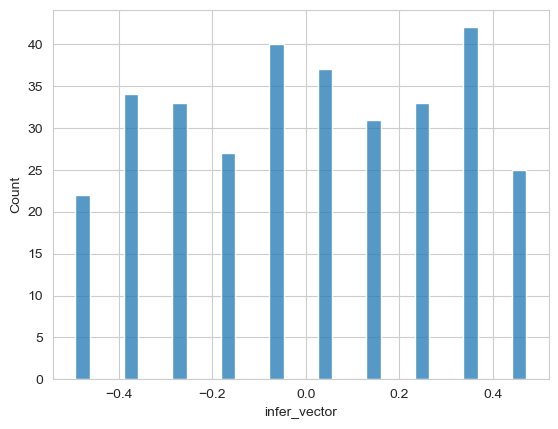

In [9]:
sns.set_style('whitegrid')
sns.histplot(data=trantor.all_records_raw_df.infer_vector[trantor.all_records_raw_df['score']  == 1], shrink=0.3)

<AxesSubplot:xlabel='infer_vector', ylabel='Count'>

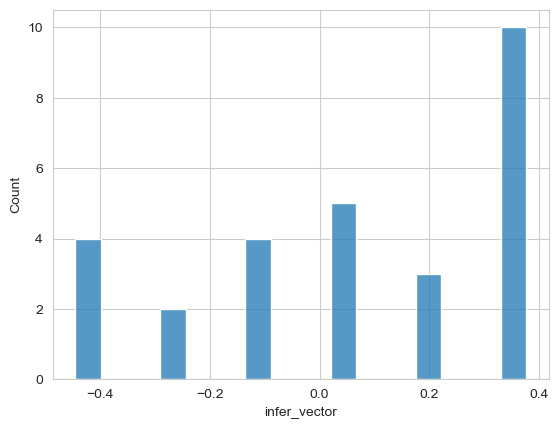

In [10]:
sns.set_style('whitegrid')
sns.histplot(data=trantor.all_records_raw_df.infer_vector[trantor.all_records_raw_df['score']  == 2], shrink=0.3)

<AxesSubplot:xlabel='infer_vector', ylabel='Count'>

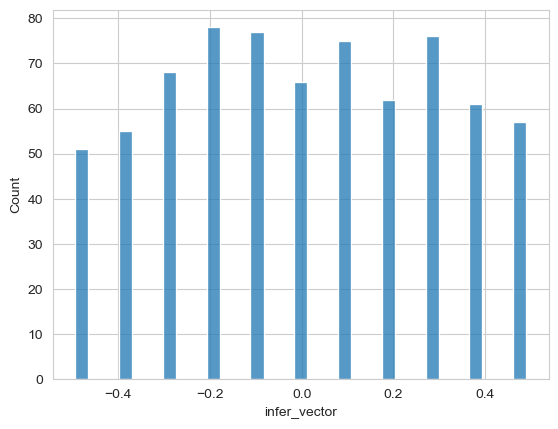

In [11]:
sns.set_style('whitegrid')
sns.histplot(data=trantor.all_records_raw_df.infer_vector[trantor.all_records_raw_df['score']  == 3], shrink=0.3)

<AxesSubplot:xlabel='infer_vector', ylabel='Count'>

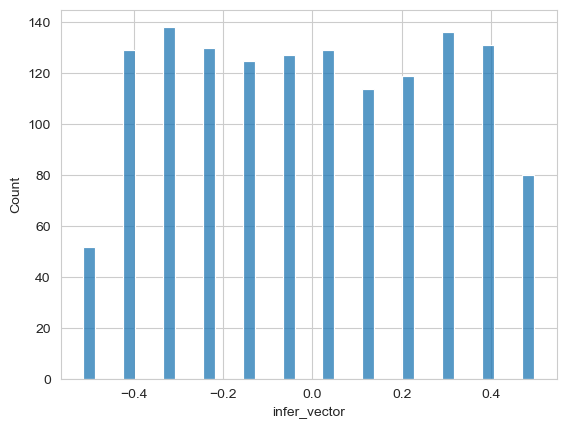

In [12]:
sns.set_style('whitegrid')
sns.histplot(data=trantor.all_records_raw_df.infer_vector[trantor.all_records_raw_df['score']  == 4], shrink=0.3)

<AxesSubplot:xlabel='infer_vector', ylabel='Count'>

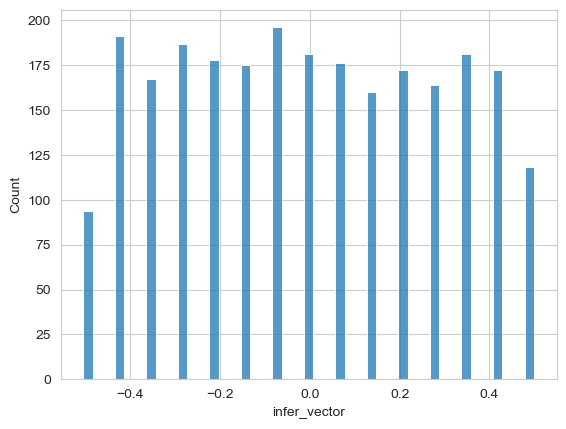

In [13]:
sns.set_style('whitegrid')
sns.histplot(data=trantor.all_records_raw_df.infer_vector[trantor.all_records_raw_df['score']  == 5], shrink=0.3)

### 3.4) Visualize the five wordclouds respectively corresponding to the set of topics that have been assigned by the model to the each class.

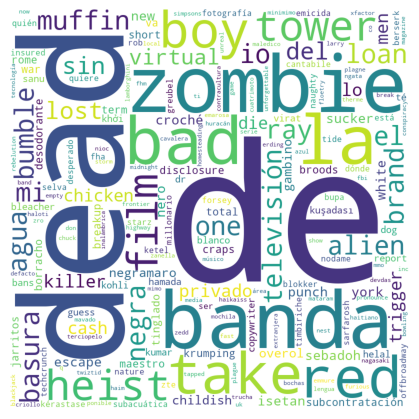

In [14]:
trantor.word_cloud(1)

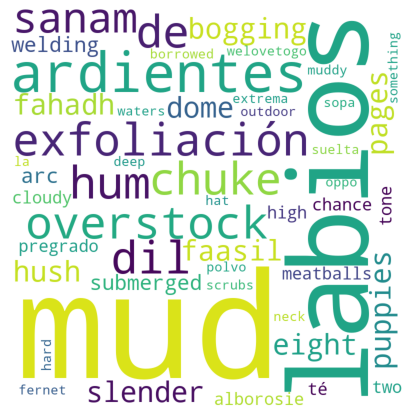

In [15]:
trantor.word_cloud(2)

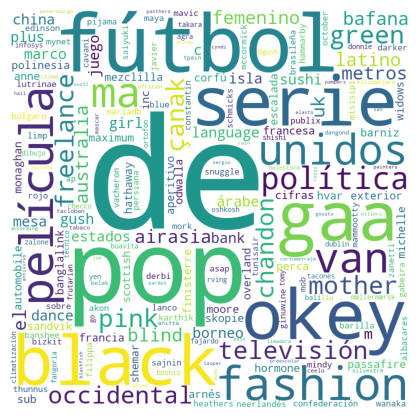

In [16]:
trantor.word_cloud(3)

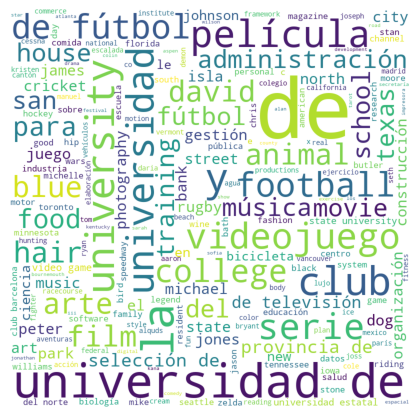

In [17]:
trantor.word_cloud(4)

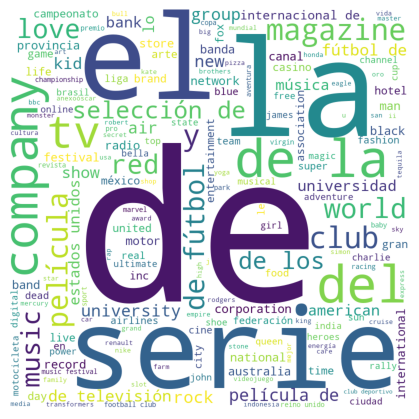

In [18]:
trantor.word_cloud(5)

### 3.5) Start from the values of semantic similarities between the target sentence "Jeu de Paume is an excellent art gallery in Paris" and each sentence in the_topics. Retrain the model "bert-base-multilingual-uncased-sentiment" or any other model from the library transformers in such a way that the model learns to predict the semantic similarity of an arbitrary sentence to the given target sentence. You should first split the_topics into sets [train, validation, test] in order to evaluate the performance of the model for the regression task.

In [19]:
df_corpus = trantor.all_records_raw_df[["name_cleaned", "target_phrase"]].rename(columns = \
                                    {"name_cleaned": "sentence1", "target_phrase": "sentence2"})
df_corpus

,sentence1,sentence2
0,Royal Doulton,Jeu de Paume is an excellent art gallery in Paris
1,Tower Heist,Jeu de Paume is an excellent art gallery in Paris
2,Bathstore,Jeu de Paume is an excellent art gallery in Paris
3,Family Guy Fans,Jeu de Paume is an excellent art gallery in Paris
4,Joseph GordonLevitt,Jeu de Paume is an excellent art gallery in Paris
...,...,...
4995,Cleaning,Jeu de Paume is an excellent art gallery in Paris
4996,Curious George serie de televisión,Jeu de Paume is an excellent art gallery in Paris
4997,Condominio,Jeu de Paume is an excellent art gallery in Paris
4998,Sime Darby,Jeu de Paume is an excellent art gallery in Paris


In [20]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [21]:
df_corpus["sentence_embedding1"] = df_corpus["sentence1"].apply(lambda row: model.encode(row))
df_corpus["sentence_embedding2"] = df_corpus["sentence2"].apply(lambda row: model.encode(row))

df_corpus

,sentence1,sentence2,sentence_embedding1,sentence_embedding2
0,Royal Doulton,Jeu de Paume is an excellent art gallery in Paris,"[0.5926711, 0.7408663, 1.175914, 0.10627427, 0...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
1,Tower Heist,Jeu de Paume is an excellent art gallery in Paris,"[0.41240144, 0.13339879, 2.0426245, -0.1083680...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
2,Bathstore,Jeu de Paume is an excellent art gallery in Paris,"[0.7810812, 0.4997214, 1.5653317, 0.16230516, ...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
3,Family Guy Fans,Jeu de Paume is an excellent art gallery in Paris,"[0.22245848, 0.036700193, 2.443649, 0.38420978...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
4,Joseph GordonLevitt,Jeu de Paume is an excellent art gallery in Paris,"[0.30429596, 0.4667488, 1.1650511, -0.13539039...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
...,...,...,...,...
4995,Cleaning,Jeu de Paume is an excellent art gallery in Paris,"[0.50421244, -0.2107748, 2.4154923, 0.41048002...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
4996,Curious George serie de televisión,Jeu de Paume is an excellent art gallery in Paris,"[0.5948577, -0.053585242, 1.4104279, 0.5451303...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
4997,Condominio,Jeu de Paume is an excellent art gallery in Paris,"[0.18687215, -0.5493834, 1.746344, 0.4969173, ...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."
4998,Sime Darby,Jeu de Paume is an excellent art gallery in Paris,"[-0.1747149, 0.107038304, 1.5124762, 0.0389028...","[0.1427047, -0.19053812, 0.4135836, 0.31591114..."


In [22]:
def cos_sim_tuned(row) -> float:
    result = util.cos_sim(row.sentence_embedding1, row.sentence_embedding2).numpy()
    return result[0][0]

In [23]:
df_corpus["cos_similiraty"] = df_corpus.apply(lambda row: cos_sim_tuned(row), axis = 1)
df_corpus

,sentence1,sentence2,sentence_embedding1,sentence_embedding2,cos_similiraty
0,Royal Doulton,Jeu de Paume is an excellent art gallery in Paris,"[0.5926711, 0.7408663, 1.175914, 0.10627427, 0...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.321013
1,Tower Heist,Jeu de Paume is an excellent art gallery in Paris,"[0.41240144, 0.13339879, 2.0426245, -0.1083680...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.326257
2,Bathstore,Jeu de Paume is an excellent art gallery in Paris,"[0.7810812, 0.4997214, 1.5653317, 0.16230516, ...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.336519
3,Family Guy Fans,Jeu de Paume is an excellent art gallery in Paris,"[0.22245848, 0.036700193, 2.443649, 0.38420978...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.292962
4,Joseph GordonLevitt,Jeu de Paume is an excellent art gallery in Paris,"[0.30429596, 0.4667488, 1.1650511, -0.13539039...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.258339
...,...,...,...,...,...
4995,Cleaning,Jeu de Paume is an excellent art gallery in Paris,"[0.50421244, -0.2107748, 2.4154923, 0.41048002...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.354360
4996,Curious George serie de televisión,Jeu de Paume is an excellent art gallery in Paris,"[0.5948577, -0.053585242, 1.4104279, 0.5451303...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.307287
4997,Condominio,Jeu de Paume is an excellent art gallery in Paris,"[0.18687215, -0.5493834, 1.746344, 0.4969173, ...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.344368
4998,Sime Darby,Jeu de Paume is an excellent art gallery in Paris,"[-0.1747149, 0.107038304, 1.5124762, 0.0389028...","[0.1427047, -0.19053812, 0.4135836, 0.31591114...",0.230538


In [24]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [25]:
tokenizer = AutoTokenizer.from_pretrained('hiiamsid/sentence_similarity_hindi')
model = AutoModel.from_pretrained('hiiamsid/sentence_similarity_hindi')

In [26]:
sentence1 = df_corpus.sentence1.tolist()

In [27]:
sentence2 = [df_corpus.sentence2[0]]

In [28]:
encoded_sentence= tokenizer(sentence2 + sentence1, padding=True, truncation=True, return_tensors="pt")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
with torch.no_grad():
    model_output = model(**encoded_sentence)

In [30]:
sentence_embed = mean_pooling(model_output, encoded_sentence['attention_mask'])

In [31]:
print(sentence_embed)

tensor([[ 1.5237, -1.0498, -1.2545,  ..., -0.9405,  0.0829, -0.3809],
        [-0.2230,  0.0418,  0.7707,  ...,  0.7347, -0.6699, -0.4577],
        [ 0.4414,  0.0398,  0.6159,  ..., -0.1875,  0.9445, -0.1835],
        ...,
        [ 0.4758,  0.0536,  0.5990,  ...,  0.3993,  0.6883, -0.7351],
        [-0.3976,  0.1469, -0.9947,  ...,  0.0532, -0.3997, -0.5848],
        [-0.0089, -1.2284, -1.3790,  ...,  1.0465, -0.8351, -1.1579]])


### In conclusion, there are many things to improve, especially the part of retrain the SBERT model, however, I think this is a job that shows the limitations of my skills and inspires me to improve them.